In [232]:
import astropy.io.fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import golden
from PIL import Image

In [11]:
path = '/home/schwarzam/Documents/testing_trilogy'

In [386]:
## params

noiselum = 0.1
satpercent = 0.1
colorsatfac = 2

dx = 338  ##tamanho desejado no final
dy = 338  ##tamanho desejado no final

In [387]:
hduR[0].data.shape

(338, 338)

In [388]:
noiselums = {'R': noiselum, 'G': noiselum, 'B': noiselum}

In [389]:
hduF378 = astropy.io.fits.open(f'{path}/Galaxy_F378.fits')
hduF395 = astropy.io.fits.open(f'{path}/Galaxy_F395.fits')
hduF410 = astropy.io.fits.open(f'{path}/Galaxy_F410.fits')
hduF430 = astropy.io.fits.open(f'{path}/Galaxy_F430.fits')
hduF515 = astropy.io.fits.open(f'{path}/Galaxy_F515.fits')
hduF660 = astropy.io.fits.open(f'{path}/Galaxy_F660.fits')
hduF861 = astropy.io.fits.open(f'{path}/Galaxy_F861.fits')
hduR = astropy.io.fits.open(f'{path}/Galaxy_R.fits')
hduG = astropy.io.fits.open(f'{path}/Galaxy_G.fits')
hduI = astropy.io.fits.open(f'{path}/Galaxy_I.fits')
hduU = astropy.io.fits.open(f'{path}/Galaxy_U.fits')
hduZ = astropy.io.fits.open(f'{path}/Galaxy_Z.fits')

In [390]:
ny, nx = hduR[0].data.shape
yc = ny / 2
xc = nx / 2

In [391]:
ylo = np.clip(yc - dy/2 + 0, 0, ny)
yhi = np.clip(yc + dy/2 + 0, 0, ny)
xlo = np.clip(xc - dx/2 + 0, 0, ny)
xhi = np.clip(xc + dx/2 + 0, 0, ny)

dx = yhi - ylo
dy = xhi - xlo

stampsRGB = np.zeros((3, int(dy), int(dx)))

In [392]:
bands = ["R", "G", "I", "U", "B", "F378", "F395", "F410", "F430", "F515", "F660", "F861"]
R = ["R", "I", "F861", "Z"]
G = ["G", "F515", "F660"]
B = ["U", "F378", "F395", "F410", "F430"]

unsatpercent = 1 - 0.01 * satpercent

In [393]:
sgn = 1
for band in bands:
    if band in R:
        exec(f"data = hdu{band}[0].data")
        data = data[int(ylo):int(yhi), int(xlo):int(xhi)]
        stampsRGB[0] = stampsRGB[0] + sgn * data
    if band in G:
        exec(f"data = hdu{band}[0].data")
        data = data[int(ylo):int(yhi), int(xlo):int(xhi)]
        stampsRGB[1] = stampsRGB[1] + sgn * data
    if band in B:
        exec(f"data = hdu{band}[0].data")
        data = data[int(ylo):int(yhi), int(xlo):int(xhi)]
        stampsRGB[2] = stampsRGB[2] + sgn * data

In [394]:
leveldict = {}
for key, band in enumerate('RGB'):
    level = get_levels(stampsRGB[key])
    leveldict[f'{band}'] = level

In [395]:
leveldict

{'R': (0, 0.27342760310832054, 15.471037864685059),
 'G': (0, 0.1526790561128982, 4.900215446949005),
 'B': (0, 0.07827197950728809, 0.7889831587672234)}

In [396]:
def get_levels(stampsRGB):
    datasorted = np.sort(stampsRGB.flat)
    datasorted[np.isnan(datasorted)] = 0

    noisesig = 1

    rem, m, r = meanstd(datasorted)
    x0 = 0

    x1 = m + noisesig * r

    x2 = setLevel(datasorted, unsatpercent)

    levels = x0, x1, x2

    return levels

def get_clip(m, m_min=None, m_max=None):
    if m_min == None:
        m_min = min(m)
    if m_max == None:
        m_max = max(m)
    
    return np.clip(m, m_min, m_max)

def setLevel(data, pp):
    vs = data
    vs = get_clip(vs, 0, None)
    
    ii = np.array(pp) * len(vs)
    ii = ii.astype('int')
    ii = np.clip(ii, 0, len(vs) - 1)
    levels = vs.take(ii)
    return levels

def rms(x):
    return np.sqrt(np.mean(x ** 2))

def meanstd(datasorted, n_sigma = 3, n = 5):
    x = datasorted

    ihi = nx = len(x)
    ilo = 0 
    
    xsort = x
    
    for i in range(n):
        xs = xsort[ilo: ihi]
        
        imed = (ilo+ihi) / 2

        aver = xs[int(imed)]
        
        std1 = np.std(xs)
        std1 = rms(xs - aver)
        
        lo = aver - n_sigma * std1
        hi = aver + n_sigma * std1
        
        ilo = np.searchsorted(xsort, lo)
        ihi = np.searchsorted(xsort, hi, side='right')
        
        nnx = ihi - ilo
        
        if nnx == nx:
            break
        else:
            nx = nnx
            
    remaining = xrem = xs[ilo:ihi]
    mean = np.mean(xrem)
    std = rms(xrem - mean)
    
    return remaining, mean, std

In [397]:
three, nx, ny = stampsRGB.shape
scaled = np.zeros(stampsRGB.shape, float)

RGB = 'RGB'
for i in range(len(RGB)):
    channel = RGB[i]
    levels = leveldict[channel]
    noiselum = noiselums[channel]
    scaled[i] = imscale(stampsRGB[i], levels, noiselum)
    
scaled = adjust_saturation(scaled, colorsatfac)
im = RGB2im(scaled)

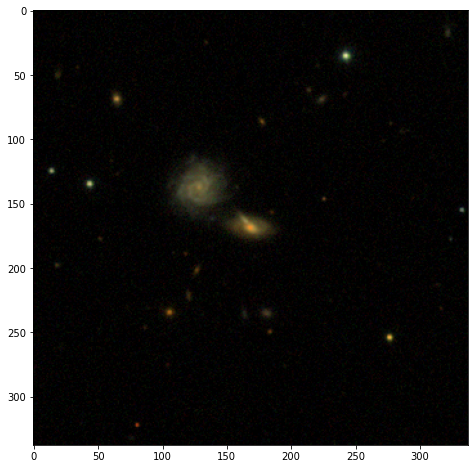

In [398]:
from astropy.visualization import make_lupton_rgb

plt.figure(figsize=(8,8))
plt.imshow(make_lupton_rgb(hduI[0].data, hduR[0].data, hduG[0].data))

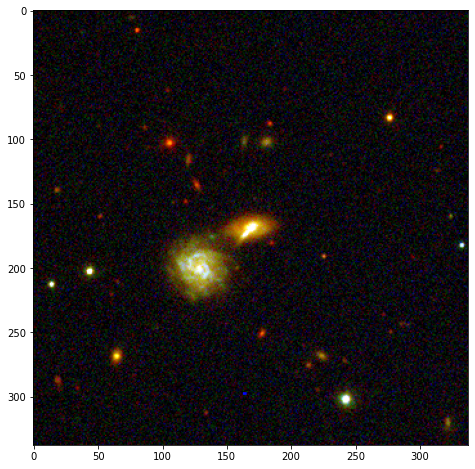

In [399]:
plt.figure(figsize=(8,8))
plt.imshow(im)

In [259]:
def RGB2im(RGB):
    data = RGB
    data = np.transpose(data, (1,2,0))  # (3, ny, nx) -> (ny, nx, 3)
    data = np.clip(data, 0, 255)
    data = data.astype('uint8')
    three = data.shape[-1]  # 3 if RGB, 1 if L
    if three == 3:
        im = Image.fromarray(data)
    elif three == 1:
        im = Image.fromarray(data[:,:,0], 'L')
    else:
        print('Data shape not understood: expect last number to be 3 for RGB, 1 for L', data.shape)
        raise Exception  # Raise generic exception and exit

    im = im.transpose(Image.FLIP_TOP_BOTTOM)
    return im

In [202]:
def da(k):
    a1 = k * (x1 - x0) + 1
    a2 = k * (x2 - x0) + 1
    a1n = a1 ** n
    a1n = np.abs(a1n)
    
    da1 = a1n - a2
    k = np.abs(k)
    
    if k == 0:
        return da(1e-10)
    else:
        da1 = da1 / k
        
    return np.abs(da1)

In [210]:
def imscale(data, levels, y1):
    global n, x0, x1, x2
    x0, x1, x2 = levels
    if y1 == 0.5:
        k = (x2 - 2 * x1 + x0) / float(x1 - x0) ** 2
    else:
        n = 1 / y1
        k = abs(golden(da))
    
    r1 = np.log10(k* (x2-x0) + 1)
    
    v = np.ravel(data)
    v = get_clip(v, 0, None)
    
    d = k * (v - x0) + 1
    d = get_clip(d, 1e-30, None)
    
    z = np.log10(d) / r1
    z = np.clip(z, 0, 1)
    z.shape = data.shape
    
    z = z * 255
    z = z.astype('uint8')
    
    return z

In [225]:
rw, gw, bw = 0.299,  0.587,  0.114  # NTSC (also used by PIL in "convert")
rw, gw, bw = 0.3086, 0.6094, 0.0820  # linear
rw, gw, bw = 0.212671, 0.715160, 0.072169  # D65: red boosted, blue muted a bit, I like it

def satK2m(K):
    m00 = rw * (1-K) + K
    m01 = gw * (1-K)
    m02 = bw * (1-K)

    m10 = rw * (1-K)
    m11 = gw * (1-K) + K
    m12 = bw * (1-K)

    m20 = rw * (1-K)
    m21 = gw * (1-K)
    m22 = bw * (1-K) + K

    m = np.array([[m00, m01, m02], [m10, m11, m12], [m20, m21, m22]])
    return m

def adjust_saturation(RGB, K):
    m = satK2m(K)
    three, nx, ny = RGB.shape
    
    RGB.shape = three, nx*ny
    
    RGB = np.dot(m, RGB)
    RGB.shape = three, nx, ny
    return RGB

In [462]:
array = []

In [463]:
for x in range(12):
    array.append(f'Galaxy_{x}')

In [465]:
array

['Galaxy_0',
 'Galaxy_1',
 'Galaxy_2',
 'Galaxy_3',
 'Galaxy_4',
 'Galaxy_5',
 'Galaxy_6',
 'Galaxy_7',
 'Galaxy_8',
 'Galaxy_9',
 'Galaxy_10',
 'Galaxy_11']

In [505]:
import astropy.io.fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import golden
from PIL import Image

rw, gw, bw = 0.299,  0.587,  0.114  # NTSC (also used by PIL in "convert")
rw, gw, bw = 0.3086, 0.6094, 0.0820  # linear
rw, gw, bw = 0.212671, 0.715160, 0.072169  # D65: red boosted, blue muted a bit, I like it

def get_levels(stampsRGB):
    datasorted = np.sort(stampsRGB.flat)
    datasorted[np.isnan(datasorted)] = 0

    noisesig = 1

    rem, m, r = meanstd(datasorted)
    x0 = 0

    x1 = m + noisesig * r

    x2 = setLevel(datasorted, unsatpercent)

    levels = x0, x1, x2

    return levels

def get_clip(m, m_min=None, m_max=None):
    if m_min == None:
        m_min = min(m)
    if m_max == None:
        m_max = max(m)
    
    return np.clip(m, m_min, m_max)

def setLevel(data, pp):
    vs = data
    vs = get_clip(vs, 0, None)
    
    ii = np.array(pp) * len(vs)
    ii = ii.astype('int')
    ii = np.clip(ii, 0, len(vs) - 1)
    levels = vs.take(ii)
    return levels

def rms(x):
    return np.sqrt(np.mean(x ** 2))

def meanstd(datasorted, n_sigma = 3, n = 5):
    x = datasorted

    ihi = nx = len(x)
    ilo = 0 
    
    xsort = x
    
    for i in range(n):
        xs = xsort[ilo: ihi]
        
        imed = (ilo+ihi) / 2

        aver = xs[int(imed)]
        
        std1 = np.std(xs)
        std1 = rms(xs - aver)
        
        lo = aver - n_sigma * std1
        hi = aver + n_sigma * std1
        
        ilo = np.searchsorted(xsort, lo)
        ihi = np.searchsorted(xsort, hi, side='right')
        
        nnx = ihi - ilo
        
        if nnx == nx:
            break
        else:
            nx = nnx
            
    remaining = xrem = xs[ilo:ihi]
    mean = np.mean(xrem)
    std = rms(xrem - mean)
    
    return remaining, mean, std

def RGB2im(RGB):
    data = RGB
    data = np.transpose(data, (1,2,0))  # (3, ny, nx) -> (ny, nx, 3)
    data = np.clip(data, 0, 255)
    data = data.astype('uint8')
    three = data.shape[-1]  # 3 if RGB, 1 if L
    if three == 3:
        im = Image.fromarray(data)
    elif three == 1:
        im = Image.fromarray(data[:,:,0], 'L')
    else:
        print('Data shape not understood: expect last number to be 3 for RGB, 1 for L', data.shape)
        raise Exception  # Raise generic exception and exit

    im = im.transpose(Image.FLIP_TOP_BOTTOM)
    return im

def da(k):
    a1 = k * (x1 - x0) + 1
    a2 = k * (x2 - x0) + 1
    a1n = a1 ** n
    a1n = np.abs(a1n)
    
    da1 = a1n - a2
    k = np.abs(k)
    
    if k == 0:
        return da(1e-10)
    else:
        da1 = da1 / k
        
    return np.abs(da1)

def imscale(data, levels, y1):
    global n, x0, x1, x2
    x0, x1, x2 = levels
    if y1 == 0.5:
        k = (x2 - 2 * x1 + x0) / float(x1 - x0) ** 2
    else:
        n = 1 / y1
        k = abs(golden(da))
    
    r1 = np.log10(k* (x2-x0) + 1)
    
    v = np.ravel(data)
    v = get_clip(v, 0, None)
    
    d = k * (v - x0) + 1
    d = get_clip(d, 1e-30, None)
    
    z = np.log10(d) / r1
    z = np.clip(z, 0, 1)
    z.shape = data.shape
    
    z = z * 255
    z = z.astype('uint8')
    
    return z

def satK2m(K):
    m00 = rw * (1-K) + K
    m01 = gw * (1-K)
    m02 = bw * (1-K)

    m10 = rw * (1-K)
    m11 = gw * (1-K) + K
    m12 = bw * (1-K)

    m20 = rw * (1-K)
    m21 = gw * (1-K)
    m22 = bw * (1-K) + K

    m = np.array([[m00, m01, m02], [m10, m11, m12], [m20, m21, m22]])
    return m

def adjust_saturation(RGB, K):
    m = satK2m(K)
    three, nx, ny = RGB.shape
    
    RGB.shape = three, nx*ny
    
    RGB = np.dot(m, RGB)
    RGB.shape = three, nx, ny
    return RGB


class MakeImg_data():
    def __init__(self, F378, F395, F410, F430, F515, F660, F861, R, G, I, U, Z, dx, dy, noiselum, satpercent, colorsatfac):
        self.dx = dx  ##tamanho desejado no final
        self.dy = dy
        sgn = 1

        global unsatpercent
        unsatpercent = 1 - 0.01 * satpercent

        self.noiselums = {'R': noiselum, 'G': noiselum, 'B': noiselum}
        
        self.hduF378 = F378
        self.hduF395 = F395
        self.hduF410 = F410
        self.hduF430 = F430
        self.hduF515 = F515
        self.hduF660 = F660
        self.hduF861 = F861
        self.hduR = R
        self.hduG = G
        self.hduI = I
        self.hduU = U
        self.hduZ = Z

        self.ny, self.nx = self.hduR.shape
        self.yc = self.ny / 2
        self.xc = self.nx / 2

        self.ylo = np.clip(self.yc - self.dy/2 + 0, 0, self.ny)
        self.yhi = np.clip(self.yc + self.dy/2 + 0, 0, self.ny)
        self.xlo = np.clip(self.xc - self.dx/2 + 0, 0, self.ny)
        self.xhi = np.clip(self.xc + self.dx/2 + 0, 0, self.ny)

        self.dx = self.yhi - self.ylo
        self.dy = self.xhi - self.xlo

        self.stampsRGB = np.zeros((3, int(self.dy), int(self.dx)))

        self.bands = ["R", "G", "I", "U", "B", "F378", "F395", "F410", "F430", "F515", "F660", "F861"]
        self.R = ["R", "I", "F861", "Z"]
        self.G = ["G", "F515", "F660"]
        self.B = ["U", "F378", "F395", "F410", "F430"]

        self.unsatpercent = 1 - 0.01 * satpercent

        self.sgn = 1
        for band in self.bands:
            if band in self.R:
                exec(f"self.data = self.hdu{band}")
                data = self.data[int(self.ylo):int(self.yhi), int(self.xlo):int(self.xhi)]
                self.stampsRGB[0] = self.stampsRGB[0] + sgn * data
            if band in self.G:
                exec(f"self.data = self.hdu{band}")
                data = self.data[int(self.ylo):int(self.yhi), int(self.xlo):int(self.xhi)]
                self.stampsRGB[1] = self.stampsRGB[1] + sgn * data
            if band in self.B:
                exec(f"self.data = self.hdu{band}")
                data = self.data[int(self.ylo):int(self.yhi), int(self.xlo):int(self.xhi)]
                self.stampsRGB[2] = self.stampsRGB[2] + sgn * data

        self.leveldict = {}
        for key, band in enumerate('RGB'):
            level = get_levels(self.stampsRGB[key])
            self.leveldict[f'{band}'] = level

        three, nx, ny = self.stampsRGB.shape
        self.scaled = np.zeros(self.stampsRGB.shape, float)

        RGB = 'RGB'
        for i in range(len(RGB)):
            self.channel = RGB[i]
            self.levels = self.leveldict[RGB[i]]
            self.noiselum = self.noiselums[RGB[i]]
            self.scaled[i] = imscale(self.stampsRGB[i], self.levels, self.noiselum)
            
        self.scaled = adjust_saturation(self.scaled, colorsatfac)
        self.im = RGB2im(self.scaled)
        
    def get(self):
        return self.im

    def get_array(self):
        return np.array(self.im)


In [503]:
noiselum = 0.1
satpercent = 0.15
colorsatfac = 2

x = MakeImg(path, 128, 128, noiselum, satpercent, colorsatfac).get_array()

In [510]:
%time
x = MakeImg_data(hduF378[0].data, hduF395[0].data
            , hduF410[0].data
            , hduF430[0].data
            , hduF515[0].data
            , hduF660[0].data
            , hduF861[0].data
            , hduR[0].data
            , hduG[0].data
            , hduI[0].data
            , hduU[0].data
            , hduZ[0].data
            , 128, 128, noiselum, satpercent, colorsatfac).get_array()



CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs


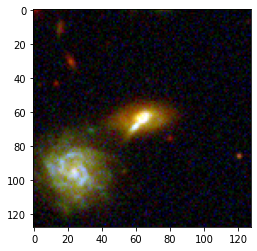

In [511]:
plt.imshow(x)